In [1]:
!pip install xgboost
!pip install numpy
!pip install pandas



     |████████████████████████████████| 686kB 5.4MB/s eta 0:00:01
  Created wheel for xgboost: filename=xgboost-0.90-cp37-cp37m-macosx_10_7_x86_64.whl size=1696839 sha256=263f4d9aec48ee18f560bae4f31256c8dc5f220633bc463cd9ac5e41d1df82fa
  Stored in directory: /Users/AliceLan/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost


In [2]:
pip install numpy==1.16.2

     |████████████████████████████████| 13.9MB 2.4MB/s eta 0:00:01     |████████████████████████████    | 12.1MB 5.9MB/s eta 0:00:01
  Found existing installation: numpy 1.17.2
    Uninstalling numpy-1.17.2:
      Successfully uninstalled numpy-1.17.2
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install seaborn

     |████████████████████████████████| 215kB 5.0MB/s eta 0:00:01


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns

In [7]:


print(pd.__version__)
print(np.__version__)

0.25.1
1.16.2


## Load Data

In [101]:
df1 = pd.read_csv('w1/loan_2014.csv')

/anaconda3/envs/nlp_proj/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (39,98) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
df1.shape

(235631, 108)

In [103]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235631 entries, 0 to 235630
Columns: 108 entries, installment to loanstatus
dtypes: float64(89), object(19)
memory usage: 194.2+ MB


## Select Data

In [104]:
all_null_feature =['inqlast12m',
 'verificationstatusjoint',
 'maxbalbc',
 'annualincjoint',
 'memberid',
 'openil6m',
 'openacc6m',
 'totalbalil',
 'inqfi',
 'mthssincercntil',
 'openrv24m',
 'openrv12m',
 'dtijoint',
 'openil12m',
 'openil24m',
 'allutil',
 'totalcutl',
 'ilutil']

In [105]:
ob_feature=['initialliststatus',
 'grade',
 'subgrade',
 'earliestcrline',
 'applicationtype',
 'intrate',
 'desc',
 'term',
 'homeownership',
 'addrstate',
 'revolutil',
 'id',
 'zipcode',
 'verificationstatus',
 'emptitle',
 'emplength',
 'purpose',
 'issued',
 'loanstatus']

In [106]:
num_feature=['bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'totalbalexmort', 'mosinrcnttl', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'bcutil', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'dti', 'delinq2yrs', 'fundedamnt', 'mosinoldilacct', 'annualinc', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'numacctsever120pd', 'accnowdelinq', 'pcttlnvrdlq', 'mthssincerecentinq', 'numiltl', 'mosinrcntrevtlop', 'openacc', 'numrevtlbalgt0', 'mthssincelastmajorderog', 'numtloppast12m', 'percentbcgt75', 'pubrecbankruptcies']

In [107]:
select_feature=ob_feature+num_feature
len(select_feature)

77

In [108]:
# remove applicationtype since it only has one value as 'individual'

ob_feature.remove('applicationtype')

In [109]:
# remove fundedamnt since it always equals to 1 for issued loans and varied during different time of a current loan

num_feature.remove('fundedamnt')


In [110]:
# remove 'id','issued' and 'loanstatus' from ob_feature, since they are index, train/test flag and target
ob_feature.remove('id')
ob_feature.remove('loanstatus')
ob_feature.remove('issued')


In [111]:
# remove 'desc' from ob_feature and select_feature
ob_feature.remove('desc')


In [112]:
select_feature=ob_feature+num_feature
len(select_feature)

71

In [113]:
# selected features left and delete the last two rows
df=df1[select_feature+['id','loanstatus','issued']][:-2]

In [114]:
df.shape

(235629, 74)

## only use term=36 months and loanstatus = fully paid and charged off

In [115]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' ")

In [116]:
df = df.query("term ==' 36 months'")


In [117]:
df.shape

(162570, 74)

In [118]:
df.drop('term', axis = 1, inplace=True)

In [119]:
df.shape

(162570, 73)

In [120]:
ob_feature.remove('term')

## Label Target

In [121]:
df['loanstatus'] = df.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [122]:
print(df.loanstatus.value_counts())
print(df.loanstatus.value_counts(normalize=True))

0    140255
1     22315
Name: loanstatus, dtype: int64
0    0.862736
1    0.137264
Name: loanstatus, dtype: float64


## Out of time testing set and in-time training set: Oct~Dec as test)

In [123]:
issued=list(df['issued'].unique())
issued

['Dec-2014',
 'Nov-2014',
 'Oct-2014',
 'Sep-2014',
 'Aug-2014',
 'Jul-2014',
 'Jun-2014',
 'May-2014',
 'Apr-2014',
 'Mar-2014',
 'Feb-2014',
 'Jan-2014']

In [124]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in issued[:3] else 1)
df.train_flg.value_counts()

1    112550
0     50020
Name: train_flg, dtype: int64

In [125]:
df.drop('issued', axis = 1, inplace=True)

In [126]:
df.shape

(162570, 73)

## Feature Engineering & Cleaning

#### Datetime to numeric feature

In [127]:
df.earliestcrline.unique()[:5]

array(['Sep-1989', 'Nov-1992', 'Aug-2002', 'Oct-1998', 'Jan-1999'],
      dtype=object)

In [128]:
# convert to number of months to Dec 2014

In [129]:
cl_month=df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year=df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [130]:
cl_month.unique()

array(['Sep', 'Nov', 'Aug', 'Oct', 'Jan', 'May', 'Jul', 'Dec', 'Jun',
       'Mar', 'Feb', 'Apr'], dtype=object)

In [131]:
cl_year.unique()

array([1989, 1992, 2002, 1998, 1999, 2001, 2009, 2003, 1993, 1996, 1995,
       2010, 2006, 2007, 2011, 2004, 2008, 1997, 1988, 1994, 2000, 1984,
       1991, 1985, 1987, 2005, 1986, 1973, 1982, 1974, 1979, 1976, 1983,
       1978, 1981, 1990, 1980, 1977, 1969, 1971, 1967, 1972, 1968, 1962,
       1975, 1965, 1966, 1963, 1970, 1964, 1958, 1955, 1959, 1961, 1960,
       1954, 1957, 1949, 1950, 1948, 1953, 1956])

In [132]:
dic_month= {'Jan':11,'Feb':10,'Mar':9,'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}

In [133]:
df['earliestcrline_month']=df.earliestcrline.apply(lambda x: (2014-int(x.split('-')[1]))*12+dic_month[x.split('-')[0]])

In [134]:
df.earliestcrline_month[:5]

0    303
2    265
5    148
6    194
7    191
Name: earliestcrline_month, dtype: int64

In [135]:
num_feature.append('earliestcrline_month')
ob_feature.remove('earliestcrline')


In [136]:
print(len(ob_feature), len(num_feature))

12 58


In [137]:
df.drop('earliestcrline', axis = 1, inplace=True)

In [138]:
df.shape

(162570, 73)

### emplength to numeric feature

In [139]:
print(df['emplength'].isnull().sum())
df['emplength'].unique()

9646


array(['8 years', '10+ years', '< 1 year', '2 years', '7 years',
       '9 years', '4 years', nan, '1 year', '5 years', '3 years',
       '6 years'], dtype=object)

In [140]:
df['emplength'].replace('n/a', np.nan, inplace=True)
df['emplength'].replace('< 1 year', '0', inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999,inplace=True)
df['emplength'] = df['emplength'].astype(int)

In [141]:
df.emplength.value_counts()

 10     51146
 2      14669
 3      13106
 0      13056
 1      10571
 4       9670
-999     9646
 5       9148
 7       8946
 6       8205
 8       8131
 9       6276
Name: emplength, dtype: int64

In [142]:
num_feature.append('emplength')
ob_feature.remove('emplength')
print(len(num_feature), len(ob_feature))

59 11


In [143]:
df.shape

(162570, 73)

## % to numeric feature: intrate, revolutil

In [144]:
intrate=df.intrate.apply(lambda x: float(x.replace('%','')))

In [145]:
df.intrate=intrate
df.intrate[:2]

0     6.99
2    13.66
Name: intrate, dtype: float64

In [146]:
df.revolutil = pd.Series(df.revolutil).str.replace('%', '').astype(float)

In [147]:
df.revolutil[:2]

0    31.6
2    59.4
Name: revolutil, dtype: float64

In [148]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')

In [149]:
print(len(ob_feature), len(num_feature))

9 61


#### Ordinal feature encoding : grade, subgrade

In [150]:
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

In [151]:
df.grade = df.grade.map(Dic_grade)

In [152]:
df.subgrade = df.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [153]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')

In [154]:
print(len(ob_feature), len(num_feature))

7 63


### High cardinality feature encoding

###### Zip Code - frequency encoding 

In [155]:
print(df.zipcode.nunique(), df.zipcode.unique()[:5])

854 ['937xx' '077xx' '850xx' '982xx' '331xx']


In [156]:
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3]))

In [157]:
zipcode_freq = df.groupby("zipcode").size().reset_index()

In [158]:
zipcode_freq[:5]

,zipcode,0
0,8,1
1,10,229
2,11,66
3,12,69
4,13,41


In [159]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [160]:
df = pd.merge(df, zipcode_freq, how = "left", on = "zipcode")

In [161]:
ob_feature.remove('zipcode')
num_feature.append('zipcode_freq')
num_feature.append('zipcode')
print(len(ob_feature), len(num_feature))

6 65


### emptitle-frequency encoding (can do some NLP for later stage)

In [162]:
emptitle_freq = df.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df = pd.merge(df, emptitle_freq, how = "left", on = "emptitle")


In [163]:
df.drop("emptitle", axis = 1, inplace=True)

In [164]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')
print(len(ob_feature), len(num_feature))

5 66


###### Addr_state - frequency encoding

In [165]:
addrstate_freq = df.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
df = pd.merge(df, addrstate_freq, how = "left", on = "addrstate")

In [166]:
df.drop("addrstate", axis = 1, inplace=True)

In [167]:
ob_feature.remove('addrstate')
num_feature.append('addrestate_freq')
print(len(ob_feature), len(num_feature))

4 67


#### One hot encoding

In [168]:
dummy_feature = ["homeownership", "verificationstatus", "purpose", "initialliststatus"]

In [169]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [170]:
df_dummy.shape

(162570, 22)

In [171]:
df=pd.concat([df,df_dummy], axis=1 )

In [172]:
df.shape

(162570, 96)

In [173]:
df.drop(dummy_feature, axis = 1, inplace=True)

In [174]:
df.shape

(162570, 92)

##  XGBoost 

In [175]:
feat=list(df.columns.values)
print(feat)

['grade', 'subgrade', 'intrate', 'revolutil', 'zipcode', 'emplength', 'bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'totalbalexmort', 'mosinrcnttl', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'bcutil', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'dti', 'delinq2yrs', 'mosinoldilacct', 'annualinc', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'numacctsever120pd', 'accnowdelinq', 'pcttlnvrdlq', 'mthssincerecentinq', 'numiltl', 'mosinrcntrevtlop', 'openacc', 'numrevtlbalgt0', 'mthssincelastmajorderog', 'numtloppast12m', 'percentbcgt75', 'pubre

In [176]:
feat.remove('id')
feat.remove('loanstatus')
feat.remove('train_flg')

### Preliminary manually parameter tuning based on stratified train-test split

In [177]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
#Kfolds = StratifiedKFold(df['loan_status'], n_folds = 3, shuffle=True, random_state=2019)

A downside of train test splits is that it can have a high variance. This means that differences in the training and test dataset can result in meaningful differences in the estimate of model accuracy.

In [178]:
# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# split data into X and y
X = df[feat]
Y = df.loanstatus
# CV model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 86.27% (0.69%)


In [179]:
df_train = df.query("train_flg == 1")
df_test =df.query("train_flg == 0" )

In [180]:
print(df_train.shape, df_test.shape)

(112550, 92) (50020, 92)


In [181]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus, 
                                                      test_size =0.3, random_state=2016, stratify = df_train.loanstatus )

In [182]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [183]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

/anaconda3/envs/nlp_proj/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/nlp_proj/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [ ]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.632, 
          "colsample_bytree": 0.7,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1441, 
          "eval_metric": "auc",
          #"gamma": 1, 
          "min_child_weight": 5} # 74453

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [107]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,\
  early_stopping_rounds= 50)

[0]	train-auc:0.672004	eval-auc:0.653256
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.684747	eval-auc:0.663707
[2]	train-auc:0.693466	eval-auc:0.667157
[3]	train-auc:0.697289	eval-auc:0.670658
[4]	train-auc:0.699708	eval-auc:0.673704
[5]	train-auc:0.701516	eval-auc:0.674168
[6]	train-auc:0.705442	eval-auc:0.675628
[7]	train-auc:0.706656	eval-auc:0.676753
[8]	train-auc:0.707715	eval-auc:0.676583
[9]	train-auc:0.707951	eval-auc:0.676576
[10]	train-auc:0.708141	eval-auc:0.676967
[11]	train-auc:0.708841	eval-auc:0.677026
[12]	train-auc:0.709622	eval-auc:0.677314
[13]	train-auc:0.710585	eval-auc:0.677805
[14]	train-auc:0.710864	eval-auc:0.678044
[15]	train-auc:0.71161	eval-auc:0.678174
[16]	train-auc:0.711797	eval-auc:0.6781
[17]	train-auc:0.71193	eval-auc:0.67803
[18]	train-auc:0.712899	eval-auc:0.678121
[19]	train-auc:0.713466	eval-auc:0.678038
[20]	train-auc:0.714009	eval-auc:0

[191]	train-auc:0.793573	eval-auc:0.688497
[192]	train-auc:0.793914	eval-auc:0.688517
[193]	train-auc:0.794229	eval-auc:0.688494
[194]	train-auc:0.794856	eval-auc:0.688601
[195]	train-auc:0.795234	eval-auc:0.688577
[196]	train-auc:0.795558	eval-auc:0.688584
[197]	train-auc:0.796033	eval-auc:0.688517
[198]	train-auc:0.796771	eval-auc:0.688577
[199]	train-auc:0.797172	eval-auc:0.688578
[200]	train-auc:0.797379	eval-auc:0.688604
[201]	train-auc:0.797733	eval-auc:0.688582
[202]	train-auc:0.79811	eval-auc:0.688659
[203]	train-auc:0.798245	eval-auc:0.688612
[204]	train-auc:0.798722	eval-auc:0.688598
[205]	train-auc:0.799152	eval-auc:0.688588
[206]	train-auc:0.799271	eval-auc:0.688571
[207]	train-auc:0.799717	eval-auc:0.68845
[208]	train-auc:0.800252	eval-auc:0.68864
[209]	train-auc:0.800456	eval-auc:0.688667
[210]	train-auc:0.800765	eval-auc:0.688619
[211]	train-auc:0.80108	eval-auc:0.688539
[212]	train-auc:0.801632	eval-auc:0.688529
[213]	train-auc:0.801895	eval-auc:0.688603
[214]	train-auc

In [108]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print("Area under the ROC curve - validation: %f" % roc_auc)
    print("Area under the ROC curve - train: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - test(AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - train (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()


### ROC curve

Area under the ROC curve - validation: 0.688785
Area under the ROC curve - train: 0.784534
Area under the ROC curve - test: 0.694702


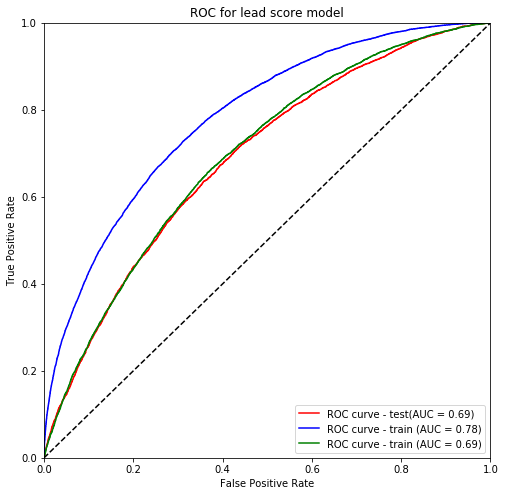

In [109]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

### Distribution of predicted values

In [110]:
y_pred = gbm.predict(dtest)

In [111]:
print(y_pred.max(), y_pred.min(), y_pred.mean())

0.68835646 0.0063878973 0.13629512


### Feature importance

In [112]:
importance=gbm.get_fscore()

In [113]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [114]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
5,dti,0.042464
4,mosinoldilacct,0.040467
2,annualinc,0.037419
16,mosinoldrevtlop,0.032584
19,installment,0.032373
39,bcutil,0.030692
12,avgcurbal,0.029956
13,revolbal,0.027538
7,emptitle_freq,0.027538
8,tothicredlim,0.026487


<Figure size 2304x2304 with 0 Axes>

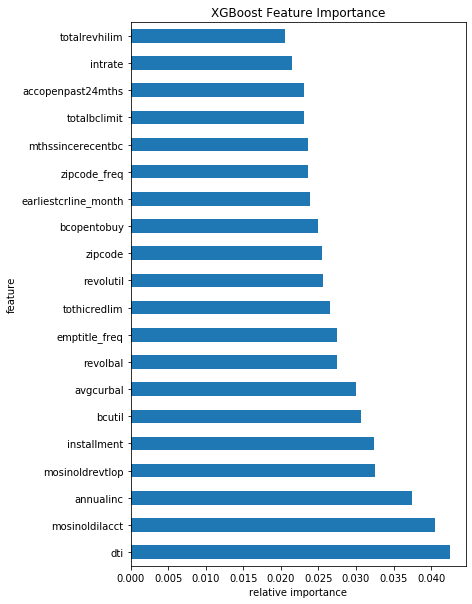

In [115]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [116]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
23,grade,0.002838


In [117]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
0,subgrade,0.015556


In [118]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
1,intrate,0.021547


In [119]:
df_importance.query("feature=='loanamnt'")

,feature,fscore
51,loanamnt,0.018394


Text(0.5, 0, 'relative importance')

<Figure size 2304x2304 with 0 Axes>

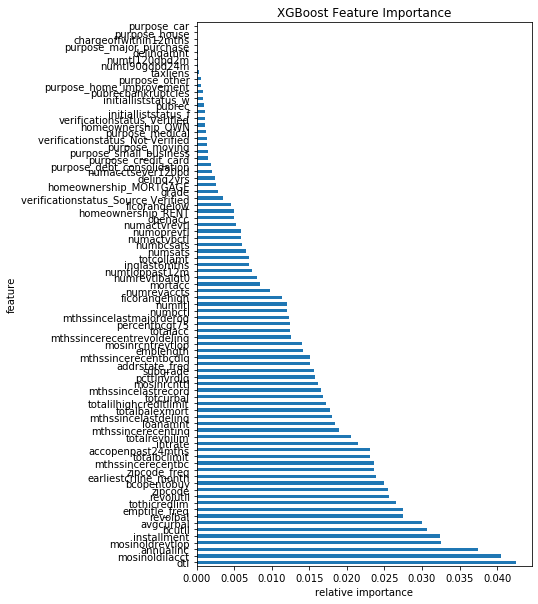

In [120]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [126]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

  Stored in directory: /home/kristianallen/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


## Hyperparameter Tuning - Bayesian Optimization

Cross-validation is used for estimating the performance of one set of parameters on unseen data.

Grid-search evaluates a model with varying parameters to find the best possible combination of these.

In [140]:
#bayesian or grid search
from bayes_opt import BayesianOptimization

train_x = df_train[feat]
train_y = df_train.loanstatus

xgtrain = xgb.DMatrix(train_x, label=train_y, missing = np.NAN)  

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 scale_pos_weight):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.05
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = False 
    params['scale_pos_weight'] = scale_pos_weight


    #use the xgboost cv function to find the best parameters for my training data set.
    cv_result = xgb.cv(params, xgtrain,
                       num_boost_round=100000,
                       nfold=3,
                       metrics={'auc'},
                       seed=1234,
                       callbacks=[xgb.callback.early_stop(50)])
    print(cv_result)

    return cv_result['test-auc-mean'].max()


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (3, 6),
                              'min_child_weight': (50,100),
                              'colsample_bytree': (0.2, 0.8),
                              'subsample': (0.5, 1),
                              'gamma': (0, 2),
                              'scale_pos_weight':(0.5,0.75)
                              #This is a constrained optimization technique, so you must specify the minimum and maximum values that can be probed for each parameter in order for it to work
                             }
                            )

xgb_BO.maximize(init_points=5, n_iter=40)

/home/kristianallen/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kristianallen/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | scale_... | subsample |
-------------------------------------------------------------------------------------------------
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[330]	train-auc:0.746014+0.00027545	test-auc:0.690106+0.00274399

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.662133       0.002551       0.655388      0.003281
1          0.669482       0.002038       0.661724      0.005160
2          0.673448       0.001787       0.664516      0.005356
3          0.674506       0.001544       0.664704      0.005206
4          0.675792       0.002410       0.666404      0.004166
5          0.677016       0.002637       0.667005      0.003817
6          0.677855       0.002733       0.667465      0.004150
7          0.678894       0.002245       0.667994      0.00

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[432]	train-auc:0.739081+0.000747754	test-auc:0.690394+0.00214023

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.658794       0.002167       0.653232      0.004732
1          0.666670       0.003119       0.660449      0.003642
2          0.670181       0.002892       0.664172      0.004522
3          0.671728       0.002806       0.665067      0.004643
4          0.672658       0.002538       0.665445      0.004182
5          0.673837       0.002167       0.665887      0.004915
6          0.674448       0.001923       0.666310      0.005050
7          0.675125       0.002386       0.666845      0.004720
8          0.675549       0.002331       0.667298      0.004543
9          0.675947       0.002228       0.667570      0.004567
10         0.676381       0.002256       0.668030      0.00444

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[579]	train-auc:0.726889+0.0013016	test-auc:0.690446+0.00194757

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.649993       0.002583       0.647256      0.002821
1          0.658492       0.002080       0.652950      0.003032
2          0.663641       0.002612       0.658536      0.003325
3          0.667220       0.003709       0.661696      0.002381
4          0.667495       0.002665       0.662514      0.003393
5          0.667613       0.002738       0.662732      0.003368
6          0.668700       0.001999       0.663845      0.004020
7          0.668696       0.001578       0.663993      0.004444
8          0.669365       0.001656       0.664640      0.004699
9          0.670519       0.002649       0.665438      0.003853
10         0.671264       0.002256       0.666149      0.004283


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[436]	train-auc:0.720312+0.00108642	test-auc:0.69+0.00213694

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.649218       0.002483       0.647374      0.002858
1          0.656269       0.003283       0.653016      0.003566
2          0.659751       0.003463       0.656244      0.003463
3          0.663256       0.003525       0.659296      0.004378
4          0.664452       0.003639       0.660425      0.004895
5          0.665316       0.004238       0.660884      0.005024
6          0.667420       0.003176       0.662576      0.004460
7          0.667901       0.002360       0.663214      0.004356
8          0.667874       0.002364       0.663511      0.004505
9          0.669089       0.003461       0.664704      0.003267
10         0.669659       0.002992       0.665755      0.003717
11 

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[304]	train-auc:0.752607+0.00046245	test-auc:0.689953+0.00200876

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.661528       0.003004       0.653367      0.004901
1          0.670846       0.002308       0.660722      0.004211
2          0.675407       0.002602       0.665102      0.004133
3          0.678014       0.002141       0.666863      0.004488
4          0.679221       0.001733       0.667412      0.004916
5          0.680461       0.002192       0.668222      0.004440
6          0.681611       0.002132       0.669298      0.004300
7          0.682326       0.001920       0.670088      0.003981
8          0.682938       0.001937       0.670692      0.004308
9          0.683650       0.001917       0.671409      0.004285
10         0.684442       0.001760       0.671809      0.004123

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[521]	train-auc:0.727216+0.000642159	test-auc:0.690501+0.00180624

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.652113       0.002755       0.648639      0.003831
1          0.657948       0.001742       0.653921      0.004849
2          0.660287       0.002535       0.655964      0.005055
3          0.662255       0.001649       0.657875      0.004918
4          0.662447       0.001671       0.658269      0.004785
5          0.663278       0.002011       0.658849      0.004910
6          0.664302       0.002048       0.659794      0.005302
7          0.664822       0.002247       0.659953      0.004967
8          0.665593       0.002312       0.660818      0.004921
9          0.666353       0.001922       0.661317      0.005315
10         0.666505       0.001991       0.661540      0.00525

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[624]	train-auc:0.732944+0.000607971	test-auc:0.690733+0.00221802

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.649907       0.002530       0.647828      0.002463
1          0.657574       0.003021       0.653595      0.005022
2          0.660271       0.002677       0.655308      0.004596
3          0.664401       0.004053       0.659019      0.003936
4          0.665099       0.003821       0.659945      0.004057
5          0.665493       0.004041       0.660566      0.003937
6          0.667030       0.003704       0.662014      0.003611
7          0.666856       0.003196       0.662212      0.003537
8          0.667032       0.002750       0.662618      0.003856
9          0.668235       0.003962       0.663757      0.002634
10         0.668757       0.003400       0.664288      0.00337

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[577]	train-auc:0.728543+0.000586702	test-auc:0.689673+0.00229406

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.653155       0.002927       0.648272      0.004635
1          0.656547       0.001067       0.651879      0.006789
2          0.659994       0.002250       0.655622      0.005437
3          0.661598       0.002776       0.657202      0.005209
4          0.661848       0.002775       0.657382      0.005026
5          0.662826       0.002081       0.658410      0.005515
6          0.663500       0.002343       0.658906      0.005714
7          0.663658       0.002208       0.659137      0.005622
8          0.664272       0.002227       0.659954      0.005496
9          0.664958       0.001997       0.660412      0.005234
10         0.665666       0.002098       0.660673      0.00510

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[672]	train-auc:0.732293+0.000759707	test-auc:0.690229+0.00202369

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.609955       0.002340       0.603333      0.004717
1          0.624759       0.004337       0.616789      0.009738
2          0.651748       0.013266       0.644868      0.018065
3          0.662641       0.006508       0.654686      0.003007
4          0.666283       0.005754       0.660018      0.001135
5          0.666609       0.005685       0.659290      0.000416
6          0.670227       0.002460       0.663531      0.004278
7          0.670979       0.001379       0.664842      0.005992
8          0.670960       0.000883       0.664607      0.006670
9          0.671497       0.001244       0.665493      0.006197
10         0.671690       0.001806       0.666170      0.00604

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[393]	train-auc:0.742223+0.0009157	test-auc:0.690746+0.00254543

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.659578       0.002043       0.654362      0.003071
1          0.665312       0.002255       0.659136      0.004883
2          0.669478       0.001880       0.662524      0.004640
3          0.671153       0.002023       0.663459      0.004101
4          0.671862       0.002066       0.664457      0.004069
5          0.673175       0.002244       0.664813      0.004248
6          0.674603       0.003546       0.666119      0.003705
7          0.675357       0.003366       0.666753      0.003800
8          0.675665       0.003228       0.667150      0.003864
9          0.677024       0.004181       0.668220      0.003354
10         0.677391       0.004188       0.668575      0.003161


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[437]	train-auc:0.737017+0.000852655	test-auc:0.690694+0.00192956

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.657107       0.003019       0.651105      0.002094
1          0.663707       0.003093       0.657245      0.002858
2          0.668964       0.002958       0.662130      0.003248
3          0.670601       0.002859       0.663711      0.003411
4          0.671399       0.002661       0.664221      0.003479
5          0.672857       0.002471       0.664904      0.003887
6          0.674432       0.003175       0.665529      0.003514
7          0.675361       0.003482       0.666588      0.003558
8          0.675833       0.003356       0.667426      0.003534
9          0.676897       0.004399       0.668256      0.002790
10         0.677079       0.004418       0.668632      0.00262

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[455]	train-auc:0.735866+0.000638016	test-auc:0.690219+0.00211928

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.654192       0.001296       0.650208      0.002343
1          0.663891       0.002452       0.655756      0.004523
2          0.669764       0.001270       0.662046      0.003820
3          0.674459       0.001966       0.665812      0.004149
4          0.674600       0.001401       0.666821      0.004367
5          0.674798       0.001571       0.667121      0.004338
6          0.675920       0.001449       0.668327      0.004486
7          0.675619       0.001473       0.668302      0.004770
8          0.676276       0.001085       0.668962      0.004931
9          0.677679       0.001908       0.669805      0.004276
10         0.678448       0.001503       0.670467      0.00462

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[596]	train-auc:0.729287+0.000778564	test-auc:0.690031+0.00241128

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.651972       0.002136       0.648985      0.003414
1          0.656237       0.002330       0.653216      0.004497
2          0.659281       0.002416       0.656143      0.004628
3          0.660827       0.003476       0.657054      0.004192
4          0.662112       0.002870       0.658130      0.004112
5          0.662543       0.002827       0.658323      0.004319
6          0.664577       0.003363       0.660062      0.004338
7          0.664741       0.003298       0.660177      0.004408
8          0.665276       0.003173       0.660944      0.004294
9          0.666219       0.004652       0.661824      0.003397
10         0.666555       0.004196       0.661811      0.00366

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[374]	train-auc:0.744665+0.000192119	test-auc:0.690492+0.00256239

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.622212       0.002067       0.607671      0.004910
1          0.640493       0.004838       0.622388      0.006001
2          0.664596       0.012277       0.647830      0.014263
3          0.675565       0.005366       0.658269      0.002776
4          0.679201       0.003410       0.663084      0.001310
5          0.678904       0.003784       0.662270      0.000895
6          0.682602       0.002553       0.667168      0.003292
7          0.683611       0.003074       0.668777      0.004772
8          0.684306       0.002972       0.669454      0.005914
9          0.684841       0.002693       0.670330      0.005635
10         0.685576       0.003058       0.671409      0.00549

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[253]	train-auc:0.744101+0.000533829	test-auc:0.689865+0.00262316

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.663993       0.003077       0.654330      0.003260
1          0.673119       0.002531       0.662236      0.003808
2          0.677421       0.002796       0.666263      0.003481
3          0.679220       0.002135       0.667349      0.004012
4          0.680738       0.002103       0.668485      0.003587
5          0.681490       0.002396       0.668744      0.004187
6          0.682641       0.002109       0.669875      0.004378
7          0.683381       0.002474       0.670391      0.003915
8          0.684221       0.002423       0.671088      0.004088
9          0.684965       0.002410       0.671470      0.004020
10         0.685624       0.002244       0.671844      0.00421

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[443]	train-auc:0.722401+0.000702	test-auc:0.690224+0.00243682

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.652055       0.002489       0.648261      0.003869
1          0.655488       0.002121       0.651410      0.005343
2          0.660983       0.003393       0.656828      0.003759
3          0.662399       0.002793       0.657597      0.003919
4          0.663559       0.002536       0.658409      0.004232
5          0.664292       0.002053       0.659093      0.005022
6          0.665056       0.001581       0.660008      0.005580
7          0.665415       0.002085       0.660525      0.005487
8          0.666086       0.001676       0.661186      0.005521
9          0.666419       0.001810       0.661545      0.005338
10         0.666657       0.002056       0.661947      0.004913
1

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[417]	train-auc:0.746141+0.000686737	test-auc:0.690256+0.00232937

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.660329       0.002095       0.654560      0.005517
1          0.666273       0.002309       0.659475      0.005873
2          0.669075       0.002259       0.661844      0.006236
3          0.671132       0.002265       0.663473      0.006036
4          0.672087       0.002175       0.664289      0.005979
5          0.673289       0.001918       0.665357      0.005872
6          0.673946       0.001934       0.665618      0.005778
7          0.674391       0.001855       0.665905      0.005728
8          0.674962       0.001694       0.666497      0.005729
9          0.675752       0.001892       0.667136      0.005220
10         0.676343       0.002180       0.667634      0.00498

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[540]	train-auc:0.725913+0.000553859	test-auc:0.690604+0.00157297

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.651764       0.002124       0.649377      0.003259
1          0.658962       0.004024       0.654943      0.004330
2          0.661163       0.002315       0.656809      0.004913
3          0.664203       0.003600       0.659611      0.004850
4          0.664770       0.003991       0.660878      0.004987
5          0.665042       0.004023       0.660633      0.004958
6          0.666278       0.004202       0.661889      0.003937
7          0.666394       0.003759       0.662143      0.003902
8          0.666568       0.003691       0.662408      0.003742
9          0.667721       0.004642       0.663298      0.002385
10         0.668506       0.003942       0.664027      0.00325

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[408]	train-auc:0.75415+0.000551293	test-auc:0.690344+0.00296264

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.662325       0.002013       0.653721      0.002124
1          0.671763       0.002323       0.660992      0.004929
2          0.675676       0.003803       0.663763      0.004037
3          0.681458       0.003708       0.668442      0.002158
4          0.682008       0.003329       0.669400      0.001874
5          0.682973       0.003702       0.669888      0.001884
6          0.684499       0.003767       0.671119      0.001915
7          0.684497       0.002745       0.671479      0.002433
8          0.685628       0.002221       0.672193      0.003343
9          0.687136       0.002925       0.673202      0.002776
10         0.687921       0.002328       0.673762      0.003309

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[370]	train-auc:0.731984+0.000764442	test-auc:0.690322+0.00197598

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.654607       0.001540       0.648539      0.002124
1          0.662704       0.003031       0.655267      0.004311
2          0.667234       0.005109       0.659016      0.002879
3          0.672889       0.004737       0.665133      0.002630
4          0.673844       0.004148       0.666359      0.002745
5          0.675187       0.004722       0.667049      0.001979
6          0.677356       0.004349       0.668739      0.002161
7          0.677425       0.003699       0.668918      0.002465
8          0.678290       0.003418       0.669433      0.002872
9          0.680081       0.003652       0.670429      0.002472
10         0.681319       0.002982       0.671678      0.00315

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[441]	train-auc:0.721825+0.000663665	test-auc:0.690224+0.00221621

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.651302       0.002775       0.648497      0.003028
1          0.658588       0.001722       0.654715      0.004316
2          0.661402       0.002377       0.657568      0.003711
3          0.662163       0.001997       0.658433      0.004465
4          0.662981       0.001955       0.658850      0.004522
5          0.663448       0.001920       0.658994      0.004728
6          0.663915       0.001864       0.659364      0.004989
7          0.664670       0.002334       0.659820      0.004775
8          0.665320       0.002342       0.660869      0.004695
9          0.665764       0.002171       0.661221      0.004804
10         0.665887       0.002279       0.661459      0.00456

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[569]	train-auc:0.726389+0.000809426	test-auc:0.690457+0.00196001

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.651240       0.002733       0.647150      0.003085
1          0.656081       0.003941       0.652025      0.003474
2          0.659683       0.002631       0.656358      0.004498
3          0.661890       0.002058       0.658019      0.005104
4          0.662924       0.001744       0.659130      0.005094
5          0.663805       0.001754       0.659751      0.005441
6          0.665364       0.002875       0.660485      0.004841
7          0.665662       0.002955       0.661017      0.004598
8          0.666069       0.002845       0.661505      0.004568
9          0.666731       0.002425       0.662054      0.004704
10         0.667011       0.002374       0.662737      0.00433

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[585]	train-auc:0.727387+0.000559991	test-auc:0.691243+0.00187746

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.650861       0.002419       0.647225      0.003369
1          0.656338       0.003253       0.651807      0.006761
2          0.660460       0.002683       0.656016      0.004435
3          0.662306       0.002492       0.658113      0.004942
4          0.663309       0.002001       0.659132      0.005371
5          0.664252       0.002117       0.660081      0.005192
6          0.664768       0.001963       0.660460      0.005371
7          0.665620       0.001733       0.661072      0.005571
8          0.665883       0.001742       0.661464      0.005906
9          0.666604       0.001536       0.662155      0.005706
10         0.667039       0.001368       0.662940      0.00540

In [141]:
print(xgb_BO.max)
#'scale_pos_weight':(0.5,0.75)
#3

{'target': 0.691243, 'params': {'colsample_bytree': 0.7681846423586742, 'gamma': 1.4116228141871918, 'max_depth': 3.411763924628986, 'min_child_weight': 99.89814239428182, 'scale_pos_weight': 0.6397931984765116, 'subsample': 0.527296089931466}}


In [135]:
print(xgb_BO.max)
#new
#'min_child_weight': (10, 30)
#2

{'target': 0.6909160000000001, 'params': {'colsample_bytree': 0.752149576479104, 'gamma': 1.4472477539883455, 'max_depth': 3.007619183678335, 'min_child_weight': 49.98195824740742, 'scale_pos_weight': 0.6920723532980972, 'subsample': 0.5161907269166064}}


In [144]:
print(xgb_BO.max)
#old
#'min_child_weight':(0,20)
#1

{'target': 0.6909160000000001, 'params': {'colsample_bytree': 0.752149576479104, 'gamma': 1.4472477539883455, 'max_depth': 3.007619183678335, 'min_child_weight': 49.98195824740742, 'scale_pos_weight': 0.6920723532980972, 'subsample': 0.5161907269166064}}


In [137]:
a = [[x["target"], x["params"]] for x in xgb_BO.res]
result = pd.DataFrame(a)
result.columns = ["target", "params"]
xgb_BO_scores = result.sort_values(by='target',ascending=False)
xgb_BO_scores["params"].head(3)

22    {'colsample_bytree': 0.752149576479104, 'gamma...
28    {'colsample_bytree': 0.4908223182086526, 'gamm...
2     {'colsample_bytree': 0.6524720235586978, 'gamm...
Name: params, dtype: object

In [138]:
%%time
# parameter set 1
params = {'objective': 'binary:logistic'
                  , 'booster': 'gbtree'
                  , 'eta': 0.01
                  , 'max_depth': 4     
                  , 'min_child_weight': 20   
                  , 'subsample': 0.62564  
                  , 'colsample_bytree': 0.627612  
                  , 'gamma': 0.052759               
                  , 'seed': 1234
                  , 'nthread': -1
                  , 'silence': 1
                  , 'eval_metric': 'auc'
                  , 'scale_pos_weight': 0.75}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round=10000
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=50)

[0]	train-auc:0.658141	eval-auc:0.654262
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.667478	eval-auc:0.661644
[2]	train-auc:0.669683	eval-auc:0.663078
[3]	train-auc:0.670461	eval-auc:0.664021
[4]	train-auc:0.67108	eval-auc:0.665071
[5]	train-auc:0.675301	eval-auc:0.668353
[6]	train-auc:0.675152	eval-auc:0.668576
[7]	train-auc:0.676186	eval-auc:0.668452
[8]	train-auc:0.675853	eval-auc:0.668396
[9]	train-auc:0.675809	eval-auc:0.668363
[10]	train-auc:0.676004	eval-auc:0.66826
[11]	train-auc:0.676125	eval-auc:0.668198
[12]	train-auc:0.675876	eval-auc:0.667883
[13]	train-auc:0.676035	eval-auc:0.667979
[14]	train-auc:0.675941	eval-auc:0.667865
[15]	train-auc:0.67587	eval-auc:0.667826
[16]	train-auc:0.675838	eval-auc:0.667771
[17]	train-auc:0.677072	eval-auc:0.668921
[18]	train-auc:0.677211	eval-auc:0.668963
[19]	train-auc:0.677454	eval-auc:0.669146
[20]	train-auc:0.677687	eval-auc

[191]	train-auc:0.686287	eval-auc:0.675103
[192]	train-auc:0.686341	eval-auc:0.675126
[193]	train-auc:0.686432	eval-auc:0.675183
[194]	train-auc:0.686458	eval-auc:0.675191
[195]	train-auc:0.686497	eval-auc:0.675216
[196]	train-auc:0.686517	eval-auc:0.675217
[197]	train-auc:0.686537	eval-auc:0.675221
[198]	train-auc:0.686589	eval-auc:0.675244
[199]	train-auc:0.686622	eval-auc:0.675256
[200]	train-auc:0.686676	eval-auc:0.675332
[201]	train-auc:0.686748	eval-auc:0.675354
[202]	train-auc:0.68682	eval-auc:0.675416
[203]	train-auc:0.686875	eval-auc:0.675439
[204]	train-auc:0.686929	eval-auc:0.67549
[205]	train-auc:0.686959	eval-auc:0.675496
[206]	train-auc:0.687004	eval-auc:0.675515
[207]	train-auc:0.68708	eval-auc:0.675543
[208]	train-auc:0.68712	eval-auc:0.675561
[209]	train-auc:0.687196	eval-auc:0.675589
[210]	train-auc:0.687238	eval-auc:0.67564
[211]	train-auc:0.687292	eval-auc:0.675687
[212]	train-auc:0.68737	eval-auc:0.675753
[213]	train-auc:0.687424	eval-auc:0.675776
[214]	train-auc:0

[383]	train-auc:0.698252	eval-auc:0.681567
[384]	train-auc:0.698303	eval-auc:0.681583
[385]	train-auc:0.69836	eval-auc:0.681597
[386]	train-auc:0.698393	eval-auc:0.681628
[387]	train-auc:0.698454	eval-auc:0.68166
[388]	train-auc:0.698558	eval-auc:0.681705
[389]	train-auc:0.698601	eval-auc:0.68174
[390]	train-auc:0.698676	eval-auc:0.681796
[391]	train-auc:0.698716	eval-auc:0.681836
[392]	train-auc:0.698804	eval-auc:0.681878
[393]	train-auc:0.69887	eval-auc:0.681937
[394]	train-auc:0.698942	eval-auc:0.681985
[395]	train-auc:0.699019	eval-auc:0.682002
[396]	train-auc:0.699105	eval-auc:0.682028
[397]	train-auc:0.699167	eval-auc:0.682041
[398]	train-auc:0.699208	eval-auc:0.68207
[399]	train-auc:0.699257	eval-auc:0.682114
[400]	train-auc:0.699346	eval-auc:0.682144
[401]	train-auc:0.699395	eval-auc:0.682173
[402]	train-auc:0.699442	eval-auc:0.682183
[403]	train-auc:0.699495	eval-auc:0.682223
[404]	train-auc:0.699558	eval-auc:0.682251
[405]	train-auc:0.699633	eval-auc:0.682299
[406]	train-auc:

[575]	train-auc:0.708824	eval-auc:0.686137
[576]	train-auc:0.708866	eval-auc:0.686169
[577]	train-auc:0.708923	eval-auc:0.68621
[578]	train-auc:0.708967	eval-auc:0.686227
[579]	train-auc:0.708995	eval-auc:0.686261
[580]	train-auc:0.709053	eval-auc:0.686272
[581]	train-auc:0.709085	eval-auc:0.686306
[582]	train-auc:0.709137	eval-auc:0.686343
[583]	train-auc:0.709214	eval-auc:0.686365
[584]	train-auc:0.709259	eval-auc:0.686374
[585]	train-auc:0.709299	eval-auc:0.68642
[586]	train-auc:0.709364	eval-auc:0.686444
[587]	train-auc:0.709404	eval-auc:0.686462
[588]	train-auc:0.709451	eval-auc:0.686468
[589]	train-auc:0.709493	eval-auc:0.686478
[590]	train-auc:0.709532	eval-auc:0.686512
[591]	train-auc:0.709581	eval-auc:0.686514
[592]	train-auc:0.709623	eval-auc:0.686537
[593]	train-auc:0.709675	eval-auc:0.686555
[594]	train-auc:0.709711	eval-auc:0.686573
[595]	train-auc:0.70974	eval-auc:0.686583
[596]	train-auc:0.709776	eval-auc:0.686577
[597]	train-auc:0.709818	eval-auc:0.686587
[598]	train-au

[767]	train-auc:0.716137	eval-auc:0.688522
[768]	train-auc:0.716169	eval-auc:0.688516
[769]	train-auc:0.716194	eval-auc:0.688522
[770]	train-auc:0.716231	eval-auc:0.688536
[771]	train-auc:0.716258	eval-auc:0.688554
[772]	train-auc:0.716318	eval-auc:0.688563
[773]	train-auc:0.716335	eval-auc:0.688585
[774]	train-auc:0.716354	eval-auc:0.688594
[775]	train-auc:0.71639	eval-auc:0.688621
[776]	train-auc:0.716436	eval-auc:0.68862
[777]	train-auc:0.716453	eval-auc:0.688624
[778]	train-auc:0.716457	eval-auc:0.688638
[779]	train-auc:0.716485	eval-auc:0.688643
[780]	train-auc:0.716525	eval-auc:0.688659
[781]	train-auc:0.716563	eval-auc:0.688667
[782]	train-auc:0.716599	eval-auc:0.688685
[783]	train-auc:0.71661	eval-auc:0.688686
[784]	train-auc:0.716636	eval-auc:0.688686
[785]	train-auc:0.71668	eval-auc:0.68868
[786]	train-auc:0.71674	eval-auc:0.688702
[787]	train-auc:0.716788	eval-auc:0.688726
[788]	train-auc:0.716832	eval-auc:0.68875
[789]	train-auc:0.716851	eval-auc:0.688737
[790]	train-auc:0.

[959]	train-auc:0.722315	eval-auc:0.689886
[960]	train-auc:0.722343	eval-auc:0.689908
[961]	train-auc:0.722368	eval-auc:0.689904
[962]	train-auc:0.722388	eval-auc:0.689913
[963]	train-auc:0.722428	eval-auc:0.689902
[964]	train-auc:0.722445	eval-auc:0.689907
[965]	train-auc:0.722489	eval-auc:0.689923
[966]	train-auc:0.722515	eval-auc:0.689924
[967]	train-auc:0.722531	eval-auc:0.689929
[968]	train-auc:0.722567	eval-auc:0.689948
[969]	train-auc:0.722597	eval-auc:0.689954
[970]	train-auc:0.722605	eval-auc:0.689961
[971]	train-auc:0.722656	eval-auc:0.68997
[972]	train-auc:0.722684	eval-auc:0.689959
[973]	train-auc:0.722707	eval-auc:0.689973
[974]	train-auc:0.722723	eval-auc:0.689975
[975]	train-auc:0.722752	eval-auc:0.689991
[976]	train-auc:0.722774	eval-auc:0.69
[977]	train-auc:0.722821	eval-auc:0.689994
[978]	train-auc:0.722854	eval-auc:0.690003
[979]	train-auc:0.722885	eval-auc:0.689993
[980]	train-auc:0.722921	eval-auc:0.689989
[981]	train-auc:0.72297	eval-auc:0.68998
[982]	train-auc:0.

[1147]	train-auc:0.727644	eval-auc:0.690687
[1148]	train-auc:0.727693	eval-auc:0.69071
[1149]	train-auc:0.727737	eval-auc:0.690712
[1150]	train-auc:0.727784	eval-auc:0.690728
[1151]	train-auc:0.727811	eval-auc:0.690713
[1152]	train-auc:0.727834	eval-auc:0.690708
[1153]	train-auc:0.727862	eval-auc:0.690719
[1154]	train-auc:0.727908	eval-auc:0.690721
[1155]	train-auc:0.727931	eval-auc:0.690725
[1156]	train-auc:0.727969	eval-auc:0.690731
[1157]	train-auc:0.728014	eval-auc:0.69075
[1158]	train-auc:0.728039	eval-auc:0.690759
[1159]	train-auc:0.728077	eval-auc:0.690772
[1160]	train-auc:0.728101	eval-auc:0.690767
[1161]	train-auc:0.728135	eval-auc:0.690765
[1162]	train-auc:0.728164	eval-auc:0.690778
[1163]	train-auc:0.728168	eval-auc:0.690789
[1164]	train-auc:0.728204	eval-auc:0.690808
[1165]	train-auc:0.728243	eval-auc:0.690811
[1166]	train-auc:0.728266	eval-auc:0.690808
[1167]	train-auc:0.728282	eval-auc:0.690807
[1168]	train-auc:0.728325	eval-auc:0.690808
[1169]	train-auc:0.728346	eval-auc

[1334]	train-auc:0.733014	eval-auc:0.691401
[1335]	train-auc:0.733036	eval-auc:0.691402
[1336]	train-auc:0.733047	eval-auc:0.691394
[1337]	train-auc:0.733093	eval-auc:0.691408
[1338]	train-auc:0.733121	eval-auc:0.691415
[1339]	train-auc:0.73315	eval-auc:0.69141
[1340]	train-auc:0.73318	eval-auc:0.691406
[1341]	train-auc:0.733205	eval-auc:0.691398
[1342]	train-auc:0.733247	eval-auc:0.6914
[1343]	train-auc:0.73326	eval-auc:0.691395
[1344]	train-auc:0.733282	eval-auc:0.691393
[1345]	train-auc:0.733306	eval-auc:0.691392
[1346]	train-auc:0.733345	eval-auc:0.691397
[1347]	train-auc:0.73338	eval-auc:0.691396
[1348]	train-auc:0.733432	eval-auc:0.69142
[1349]	train-auc:0.733456	eval-auc:0.691413
[1350]	train-auc:0.733492	eval-auc:0.691413
[1351]	train-auc:0.733536	eval-auc:0.691419
[1352]	train-auc:0.733574	eval-auc:0.691426
[1353]	train-auc:0.733622	eval-auc:0.691429
[1354]	train-auc:0.733643	eval-auc:0.691426
[1355]	train-auc:0.733664	eval-auc:0.69142
[1356]	train-auc:0.733689	eval-auc:0.6914

[1522]	train-auc:0.73801	eval-auc:0.691822
[1523]	train-auc:0.738035	eval-auc:0.691816
[1524]	train-auc:0.738072	eval-auc:0.691817
[1525]	train-auc:0.738099	eval-auc:0.691809
[1526]	train-auc:0.738109	eval-auc:0.691821
[1527]	train-auc:0.73813	eval-auc:0.691823
[1528]	train-auc:0.738159	eval-auc:0.691828
[1529]	train-auc:0.738188	eval-auc:0.691825
[1530]	train-auc:0.738206	eval-auc:0.691828
[1531]	train-auc:0.738228	eval-auc:0.691835
[1532]	train-auc:0.73824	eval-auc:0.691836
[1533]	train-auc:0.738266	eval-auc:0.69184
[1534]	train-auc:0.738285	eval-auc:0.691843
[1535]	train-auc:0.738317	eval-auc:0.691833
[1536]	train-auc:0.738345	eval-auc:0.691842
[1537]	train-auc:0.738356	eval-auc:0.69185
[1538]	train-auc:0.738371	eval-auc:0.691848
[1539]	train-auc:0.738387	eval-auc:0.691841
[1540]	train-auc:0.738408	eval-auc:0.691845
[1541]	train-auc:0.738419	eval-auc:0.69185
[1542]	train-auc:0.738455	eval-auc:0.691856
[1543]	train-auc:0.738479	eval-auc:0.691862
[1544]	train-auc:0.738499	eval-auc:0.6

[1710]	train-auc:0.742491	eval-auc:0.692229
[1711]	train-auc:0.742511	eval-auc:0.692227
[1712]	train-auc:0.742533	eval-auc:0.692225
[1713]	train-auc:0.742546	eval-auc:0.692224
[1714]	train-auc:0.742585	eval-auc:0.692236
[1715]	train-auc:0.74261	eval-auc:0.692232
[1716]	train-auc:0.742639	eval-auc:0.69223
[1717]	train-auc:0.742682	eval-auc:0.692233
[1718]	train-auc:0.742718	eval-auc:0.692228
[1719]	train-auc:0.742769	eval-auc:0.692231
[1720]	train-auc:0.742803	eval-auc:0.692237
[1721]	train-auc:0.742821	eval-auc:0.69223
[1722]	train-auc:0.742836	eval-auc:0.692241
[1723]	train-auc:0.74285	eval-auc:0.692239
[1724]	train-auc:0.7429	eval-auc:0.692244
[1725]	train-auc:0.742919	eval-auc:0.692235
[1726]	train-auc:0.742961	eval-auc:0.692239
[1727]	train-auc:0.742979	eval-auc:0.692238
[1728]	train-auc:0.742997	eval-auc:0.692249
[1729]	train-auc:0.743019	eval-auc:0.69225
[1730]	train-auc:0.74304	eval-auc:0.69223
[1731]	train-auc:0.743077	eval-auc:0.692249
[1732]	train-auc:0.743089	eval-auc:0.6922

[1898]	train-auc:0.746869	eval-auc:0.692488
[1899]	train-auc:0.746887	eval-auc:0.69249
[1900]	train-auc:0.746903	eval-auc:0.692487
[1901]	train-auc:0.746929	eval-auc:0.692494
[1902]	train-auc:0.746961	eval-auc:0.692495
[1903]	train-auc:0.746983	eval-auc:0.692492
[1904]	train-auc:0.74701	eval-auc:0.692489
[1905]	train-auc:0.747043	eval-auc:0.692486
[1906]	train-auc:0.747068	eval-auc:0.692502
[1907]	train-auc:0.747086	eval-auc:0.692527
[1908]	train-auc:0.747117	eval-auc:0.692539
[1909]	train-auc:0.747142	eval-auc:0.69255
[1910]	train-auc:0.747161	eval-auc:0.692539
[1911]	train-auc:0.74716	eval-auc:0.692536
[1912]	train-auc:0.747187	eval-auc:0.692552
[1913]	train-auc:0.747202	eval-auc:0.692548
[1914]	train-auc:0.747211	eval-auc:0.69255
[1915]	train-auc:0.747231	eval-auc:0.692556
[1916]	train-auc:0.74725	eval-auc:0.692563
[1917]	train-auc:0.747279	eval-auc:0.692564
[1918]	train-auc:0.747299	eval-auc:0.692572
[1919]	train-auc:0.747334	eval-auc:0.692568
[1920]	train-auc:0.747377	eval-auc:0.6

In [140]:
%%time
# parameter set 2
params = {'objective': 'binary:logistic'
                  , 'booster': 'gbtree'
                  , 'eta': 0.01
                  , 'max_depth': 4     
                  , 'min_child_weight': 18   
                  , 'subsample': 0.74657   
                  , 'colsample_bytree': 0.261858  
                  , 'gamma': 0.57485               
                  , 'seed': 1234
                  , 'nthread': -1
                  , 'silence': 1
                  , 'eval_metric': 'auc'
                  , 'scale_pos_weight': 0.75}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round=10000
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=50)

# [3393]	train-auc:0.772549	eval-auc:0.728445

[0]	train-auc:0.655001	eval-auc:0.652195
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.666292	eval-auc:0.658873
[2]	train-auc:0.669471	eval-auc:0.659461
[3]	train-auc:0.673929	eval-auc:0.665207
[4]	train-auc:0.673941	eval-auc:0.665291
[5]	train-auc:0.672637	eval-auc:0.664413
[6]	train-auc:0.675191	eval-auc:0.667162
[7]	train-auc:0.677184	eval-auc:0.669768
[8]	train-auc:0.677414	eval-auc:0.670142
[9]	train-auc:0.676552	eval-auc:0.669622
[10]	train-auc:0.676877	eval-auc:0.66983
[11]	train-auc:0.678736	eval-auc:0.671521
[12]	train-auc:0.679965	eval-auc:0.672351
[13]	train-auc:0.680421	eval-auc:0.672226
[14]	train-auc:0.681425	eval-auc:0.672564
[15]	train-auc:0.681644	eval-auc:0.67283
[16]	train-auc:0.681924	eval-auc:0.672939
[17]	train-auc:0.68232	eval-auc:0.673078
[18]	train-auc:0.683059	eval-auc:0.673251
[19]	train-auc:0.683138	eval-auc:0.673402
[20]	train-auc:0.683116	eval-auc

[191]	train-auc:0.688853	eval-auc:0.676761
[192]	train-auc:0.688799	eval-auc:0.676693
[193]	train-auc:0.688778	eval-auc:0.676695
[194]	train-auc:0.688839	eval-auc:0.67674
[195]	train-auc:0.688814	eval-auc:0.676714
[196]	train-auc:0.688787	eval-auc:0.676725
[197]	train-auc:0.688795	eval-auc:0.676726
[198]	train-auc:0.68891	eval-auc:0.67675
[199]	train-auc:0.689076	eval-auc:0.676836
[200]	train-auc:0.689128	eval-auc:0.676843
[201]	train-auc:0.68921	eval-auc:0.676848
[202]	train-auc:0.689292	eval-auc:0.676886
[203]	train-auc:0.689255	eval-auc:0.676863
[204]	train-auc:0.689236	eval-auc:0.676861
[205]	train-auc:0.689237	eval-auc:0.676894
[206]	train-auc:0.689194	eval-auc:0.676869
[207]	train-auc:0.689148	eval-auc:0.676837
[208]	train-auc:0.689163	eval-auc:0.676851
[209]	train-auc:0.689181	eval-auc:0.67687
[210]	train-auc:0.689181	eval-auc:0.676876
[211]	train-auc:0.689192	eval-auc:0.676899
[212]	train-auc:0.689264	eval-auc:0.676925
[213]	train-auc:0.689236	eval-auc:0.676928
[214]	train-auc:

[383]	train-auc:0.696964	eval-auc:0.681209
[384]	train-auc:0.697017	eval-auc:0.681206
[385]	train-auc:0.697051	eval-auc:0.681234
[386]	train-auc:0.697109	eval-auc:0.681247
[387]	train-auc:0.697135	eval-auc:0.681274
[388]	train-auc:0.697229	eval-auc:0.681341
[389]	train-auc:0.697316	eval-auc:0.681403
[390]	train-auc:0.697337	eval-auc:0.681408
[391]	train-auc:0.697413	eval-auc:0.681422
[392]	train-auc:0.697449	eval-auc:0.681449
[393]	train-auc:0.697522	eval-auc:0.681473
[394]	train-auc:0.697596	eval-auc:0.681532
[395]	train-auc:0.697605	eval-auc:0.681555
[396]	train-auc:0.697677	eval-auc:0.681588
[397]	train-auc:0.697747	eval-auc:0.681613
[398]	train-auc:0.697781	eval-auc:0.68165
[399]	train-auc:0.697852	eval-auc:0.68168
[400]	train-auc:0.697877	eval-auc:0.681679
[401]	train-auc:0.697888	eval-auc:0.681691
[402]	train-auc:0.69794	eval-auc:0.681716
[403]	train-auc:0.698021	eval-auc:0.681788
[404]	train-auc:0.698086	eval-auc:0.68182
[405]	train-auc:0.698121	eval-auc:0.681844
[406]	train-auc

[575]	train-auc:0.706409	eval-auc:0.685413
[576]	train-auc:0.706434	eval-auc:0.685414
[577]	train-auc:0.706499	eval-auc:0.685429
[578]	train-auc:0.706547	eval-auc:0.685458
[579]	train-auc:0.706597	eval-auc:0.685492
[580]	train-auc:0.706618	eval-auc:0.685503
[581]	train-auc:0.706646	eval-auc:0.685511
[582]	train-auc:0.706684	eval-auc:0.685528
[583]	train-auc:0.706728	eval-auc:0.685545
[584]	train-auc:0.706767	eval-auc:0.685543
[585]	train-auc:0.706795	eval-auc:0.685562
[586]	train-auc:0.706838	eval-auc:0.685582
[587]	train-auc:0.706886	eval-auc:0.685604
[588]	train-auc:0.706931	eval-auc:0.685619
[589]	train-auc:0.706966	eval-auc:0.685611
[590]	train-auc:0.707022	eval-auc:0.685616
[591]	train-auc:0.707063	eval-auc:0.685644
[592]	train-auc:0.7071	eval-auc:0.685664
[593]	train-auc:0.707152	eval-auc:0.685669
[594]	train-auc:0.707193	eval-auc:0.68569
[595]	train-auc:0.70724	eval-auc:0.685704
[596]	train-auc:0.707297	eval-auc:0.685733
[597]	train-auc:0.70735	eval-auc:0.685766
[598]	train-auc:

[767]	train-auc:0.713658	eval-auc:0.68766
[768]	train-auc:0.713694	eval-auc:0.687661
[769]	train-auc:0.713716	eval-auc:0.68767
[770]	train-auc:0.713772	eval-auc:0.687668
[771]	train-auc:0.713804	eval-auc:0.687679
[772]	train-auc:0.713843	eval-auc:0.687696
[773]	train-auc:0.713881	eval-auc:0.687726
[774]	train-auc:0.713913	eval-auc:0.687719
[775]	train-auc:0.713956	eval-auc:0.687722
[776]	train-auc:0.71398	eval-auc:0.687724
[777]	train-auc:0.714024	eval-auc:0.687724
[778]	train-auc:0.714029	eval-auc:0.68773
[779]	train-auc:0.714078	eval-auc:0.687733
[780]	train-auc:0.714106	eval-auc:0.687762
[781]	train-auc:0.714139	eval-auc:0.687781
[782]	train-auc:0.71417	eval-auc:0.687801
[783]	train-auc:0.714209	eval-auc:0.687806
[784]	train-auc:0.714232	eval-auc:0.687808
[785]	train-auc:0.71427	eval-auc:0.687823
[786]	train-auc:0.714322	eval-auc:0.687818
[787]	train-auc:0.714361	eval-auc:0.687822
[788]	train-auc:0.714382	eval-auc:0.687821
[789]	train-auc:0.71441	eval-auc:0.687818
[790]	train-auc:0.

[959]	train-auc:0.719512	eval-auc:0.689068
[960]	train-auc:0.719535	eval-auc:0.689084
[961]	train-auc:0.719548	eval-auc:0.68907
[962]	train-auc:0.719573	eval-auc:0.689066
[963]	train-auc:0.719584	eval-auc:0.68907
[964]	train-auc:0.71961	eval-auc:0.68908
[965]	train-auc:0.719639	eval-auc:0.68907
[966]	train-auc:0.719668	eval-auc:0.689069
[967]	train-auc:0.719708	eval-auc:0.689072
[968]	train-auc:0.719723	eval-auc:0.689069
[969]	train-auc:0.719762	eval-auc:0.689077
[970]	train-auc:0.719777	eval-auc:0.689083
[971]	train-auc:0.719811	eval-auc:0.689095
[972]	train-auc:0.719844	eval-auc:0.689102
[973]	train-auc:0.719884	eval-auc:0.689128
[974]	train-auc:0.719905	eval-auc:0.689129
[975]	train-auc:0.719932	eval-auc:0.689136
[976]	train-auc:0.719954	eval-auc:0.689139
[977]	train-auc:0.719993	eval-auc:0.689122
[978]	train-auc:0.720027	eval-auc:0.68911
[979]	train-auc:0.720047	eval-auc:0.689126
[980]	train-auc:0.720058	eval-auc:0.689125
[981]	train-auc:0.720095	eval-auc:0.689126
[982]	train-auc:0

[1148]	train-auc:0.724574	eval-auc:0.690108
[1149]	train-auc:0.724617	eval-auc:0.690109
[1150]	train-auc:0.724642	eval-auc:0.690114
[1151]	train-auc:0.724681	eval-auc:0.690115
[1152]	train-auc:0.724697	eval-auc:0.690119
[1153]	train-auc:0.724712	eval-auc:0.690113
[1154]	train-auc:0.724749	eval-auc:0.690104
[1155]	train-auc:0.724776	eval-auc:0.690101
[1156]	train-auc:0.724791	eval-auc:0.690101
[1157]	train-auc:0.724824	eval-auc:0.690118
[1158]	train-auc:0.724836	eval-auc:0.690113
[1159]	train-auc:0.724869	eval-auc:0.690107
[1160]	train-auc:0.724897	eval-auc:0.690108
[1161]	train-auc:0.724908	eval-auc:0.690118
[1162]	train-auc:0.724925	eval-auc:0.690119
[1163]	train-auc:0.724938	eval-auc:0.690119
[1164]	train-auc:0.724963	eval-auc:0.690123
[1165]	train-auc:0.724978	eval-auc:0.690122
[1166]	train-auc:0.724991	eval-auc:0.690113
[1167]	train-auc:0.725025	eval-auc:0.69011
[1168]	train-auc:0.725073	eval-auc:0.69013
[1169]	train-auc:0.7251	eval-auc:0.690123
[1170]	train-auc:0.725143	eval-auc:0

[1335]	train-auc:0.729198	eval-auc:0.690806
[1336]	train-auc:0.729208	eval-auc:0.690811
[1337]	train-auc:0.729245	eval-auc:0.690804
[1338]	train-auc:0.729275	eval-auc:0.690808
[1339]	train-auc:0.729307	eval-auc:0.690815
[1340]	train-auc:0.729347	eval-auc:0.690808
[1341]	train-auc:0.729382	eval-auc:0.690801
[1342]	train-auc:0.7294	eval-auc:0.690786
[1343]	train-auc:0.729421	eval-auc:0.690788
[1344]	train-auc:0.729456	eval-auc:0.690808
[1345]	train-auc:0.729461	eval-auc:0.690801
[1346]	train-auc:0.729471	eval-auc:0.690792
[1347]	train-auc:0.729513	eval-auc:0.69079
[1348]	train-auc:0.72954	eval-auc:0.690805
[1349]	train-auc:0.729562	eval-auc:0.690801
[1350]	train-auc:0.72958	eval-auc:0.690799
[1351]	train-auc:0.729589	eval-auc:0.690796
[1352]	train-auc:0.729604	eval-auc:0.690789
[1353]	train-auc:0.729633	eval-auc:0.69079
[1354]	train-auc:0.729652	eval-auc:0.690789
[1355]	train-auc:0.729681	eval-auc:0.690804
[1356]	train-auc:0.7297	eval-auc:0.690809
[1357]	train-auc:0.729711	eval-auc:0.690

[1523]	train-auc:0.73353	eval-auc:0.691146
[1524]	train-auc:0.733543	eval-auc:0.691145
[1525]	train-auc:0.733565	eval-auc:0.691134
[1526]	train-auc:0.733585	eval-auc:0.691122
[1527]	train-auc:0.733605	eval-auc:0.691124
[1528]	train-auc:0.733635	eval-auc:0.691126
[1529]	train-auc:0.733648	eval-auc:0.691119
[1530]	train-auc:0.733681	eval-auc:0.691118
[1531]	train-auc:0.733716	eval-auc:0.691127
[1532]	train-auc:0.733739	eval-auc:0.691136
[1533]	train-auc:0.73378	eval-auc:0.691132
[1534]	train-auc:0.733812	eval-auc:0.691126
[1535]	train-auc:0.733836	eval-auc:0.691139
[1536]	train-auc:0.733848	eval-auc:0.691146
[1537]	train-auc:0.733865	eval-auc:0.691155
[1538]	train-auc:0.733899	eval-auc:0.69114
[1539]	train-auc:0.733924	eval-auc:0.691129
[1540]	train-auc:0.733931	eval-auc:0.691124
[1541]	train-auc:0.733948	eval-auc:0.691122
[1542]	train-auc:0.73399	eval-auc:0.691123
[1543]	train-auc:0.734012	eval-auc:0.691123
[1544]	train-auc:0.734041	eval-auc:0.691129
[1545]	train-auc:0.734049	eval-auc:0

## train model with tuned parameters

Area under the ROC curve - validation: 0.691271
Area under the ROC curve - train: 0.736032
Area under the ROC curve - test: 0.698253


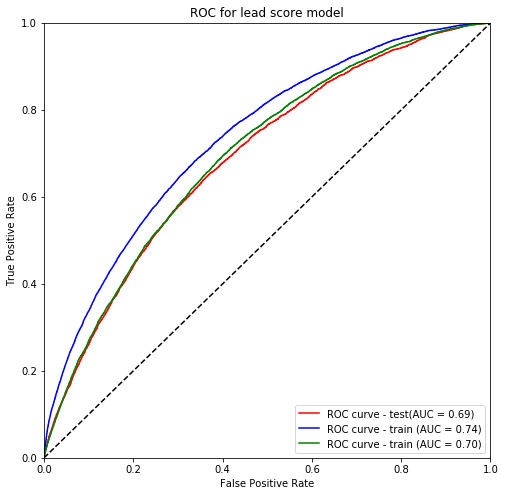

In [156]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

In [139]:
best_xgb_iteration=1924
clf_train = xgb.XGBClassifier(learning_rate = 0.01
                  , n_estimators =best_xgb_iteration
                  , max_depth = 4
                  , min_child_weight = 18
                  , subsample = 0.74657
                  , colsample_bytree = 0.261858 
                  , gamma = 0.57485
                  , seed = 1234
                  , nthread = -1
                  , scale_pos_weight = 1
                  )

clf_train.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.261858, gamma=0.57485,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=18, missing=None, n_estimators=1924, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
              silent=None, subsample=0.74657, verbosity=1)

## validate on test data

Area under the ROC curve - validation: 0.691271
Area under the ROC curve - train: 0.736032
Area under the ROC curve - test: 0.698253


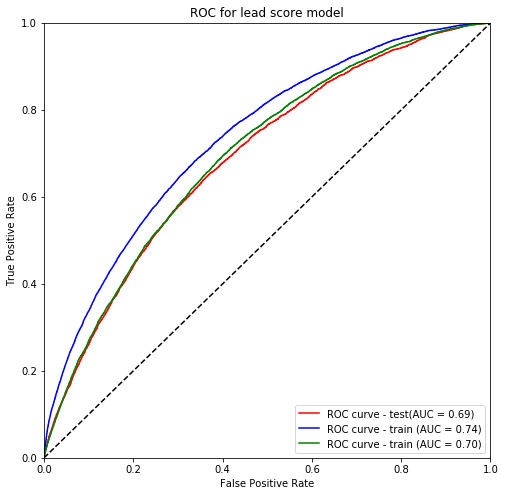

In [141]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)
#体现的是相对坏账率的大小 to show the relative defult rates

In [137]:
y_pred = gbm.predict(dtest)

In [159]:
y_pred

array([0.04848513, 0.20660293, 0.22560365, ..., 0.24204339, 0.32959422,
       0.07138613], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred.round())



In [138]:
print(y_pred.max(), y_pred.min(), y_pred.mean())

0.7592241 0.0064729247 0.13688941


In [139]:
importance=gbm.get_fscore()

In [140]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [141]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
30,dti,0.038662
15,mosinoldilacct,0.036601
21,installment,0.035718
26,mosinoldrevtlop,0.033853
41,annualinc,0.031597
18,emptitle_freq,0.028947
31,bcutil,0.028358
36,zipcode,0.028162
49,revolbal,0.026494
12,bcopentobuy,0.026101


<Figure size 2304x2304 with 0 Axes>

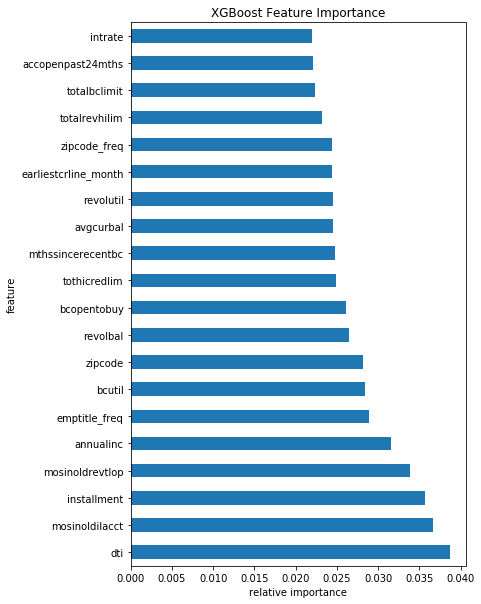

In [142]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

## Save model

In [143]:
import pickle

In [144]:
with open('model.pkl','wb') as pkl_file:
    pickle.dump(gbm, pkl_file)

In [145]:
from sklearn.externals import joblib
joblib.dump(gbm, "pima.joblib.dat")

['pima.joblib.dat']

In [1]:
!pip install lightgbm
import lightgbm as lgb

    100% |████████████████████████████████| 686kB 8.0MB/s eta 0:00:01


OSError: dlopen(/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

In [94]:
df_train = df.query("train_flg == 1")
df_test =df.query("train_flg == 0" )
train_x = df_train[feat]
train_y = df_train.loanstatus

In [95]:
d_train = lgb.Dataset(train_x, label=train_y)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

#X_train, X_valid, y_train, y_valid 
#X_test, y_test

NameError: name 'lgb' is not defined

In [110]:
y_pred=clf.predict(X_test)

for i in range(0,len(y_pred)):
    if y_pred[i]>=.5:      
        y_pred[i]=1
    else:  
        y_pred[i]=0

In [111]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [115]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [117]:
cm = confusion_matrix(y_test, y_pred)
#Accuracyfrom sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)

In [118]:
cm

array([[42753,     0],
       [ 7267,     0]])

In [119]:
accuracy

0.8547181127548981

In [122]:
from bayes_opt import BayesianOptimization
def lgb_evaluate(                
                numLeaves,
                maxDepth,
                scaleWeight,
                minChildWeight,
                subsample,
                colSam
                ):
    
    clf = lgb.LGBMClassifier(
        objective = 'binary',
        metric= 'auc',
        eval_metric= 'auc',
        reg_alpha= 0,
        reg_lambda= 2,
        bagging_fraction= 0.999,
        min_split_gain= 0,
        min_child_samples= 10,
        subsample_freq= 3,
        subsample_for_bin= 50000,
        n_estimators= 9999999,
        num_leaves= int(numLeaves),
        max_depth= int(maxDepth),
        scale_pos_weight= scaleWeight,
        min_child_weight= minChildWeight,
        subsample= subsample,
        colsample_bytree= colSam,
        verbose =-1
    )
    
    scores = cross_val_score(clf, train_x, train_y, cv=5, scoring='roc_auc')
    print(np.mean(scores))

    return np.mean(scores)

In [137]:
import time

In [138]:
# https://gist.github.com/mohit-sinha/be3f2999eb21d1992d03b7590fe2d88b




In [139]:
start_time = time.time()

lgbBO = BayesianOptimization(lgb_evaluate, {                                                
                                                'numLeaves':  (5, 50),
                                                'maxDepth': (2, 63),
                                                'scaleWeight': (1, 10000),
                                                'minChildWeight': (0.01, 70),
                                                'subsample': (0.4, 1),                                                
                                                'colSam': (0.4, 1)
                                            })


lgbBO.maximize(init_points=5, n_iter=40)

print(lgbBO.res['max'])
    

bayesOpt(train_x, train_y)
end_time = time.time()
print(end_time - start_time)

|   iter    |  target   |  colSam   | maxDepth  | minChi... | numLeaves | scaleW... | subsample |
-------------------------------------------------------------------------------------------------


KeyboardInterrupt: 